## 第二章 建模仿真原理：奶茶问题（Part 1）

### 奶茶问题（Part 1）

##### 问题描述：
假设我在家泡了杯热茶，还带了杯从冰箱里拿出来的牛奶，开车去上班，我希望上班的时候能喝上热奶茶。那我是在家出发的时候把牛奶倒进热茶里，还是在开车上班的途中某个时间点把牛奶倒进热茶里呢？

##### 一些假设：
1.刚泡的热茶温度为90摄氏度，有300mL。

2.牛奶从冰箱里拿出来的温度为5摄氏度，有50mL。

3.车里的环境温度为22摄氏度。

4.茶泡在保温杯里，从家到单位路程为30分钟，茶的温度降到了70摄氏度。

5.牛奶瓶不保温，15分钟后就会升温到20摄氏度，接近车内环境温度。


### 牛顿冷却定律
很多系统都具有的一个物理特性就是系统的状态会随着时间的变化而变化，比如，一杯茶降温的速度取决于茶杯中茶的温度。该系统服从牛顿冷却定律，某个对象温度降低的速度正比于其本身温度与环境温度之间的差异。从数学上看，该系统可以用如下简单的微分方程表示：
$${{dT}\over{dt}}=-r(T-T_a)$$
式中，$T$为液体的温度，$t$为时间，$r$为比例常数表示热量在液体和环境之间的传递速度，$T_a$为环境温度。该方程的解表明温度的衰减为时间的指数。如果$k$和$T_a$已知，该方程的解可以利用初始温度和时间的函数对温度进行预测。

这个牛顿冷却定律就是一个数学模型：它在某些情况下是一个对现实较好的近似，但在另一些情况下则不太好。比如，热传递是由于温度差引起的热能传递现象，一般有三种基本形式：热传导、对流和热辐射。热传导是介质内无宏观运动时的传热现象，温度通过保温杯杯壁传导出去就是这种形式。牛顿冷却定律对于热传导是基本成立的。比例常数$r$在一个很宽的温度范围内都是常数。有时候我们可以通过介质材料特性和物理形状来估计常数$r$。

当对流占热传递的比重较大的时候，常数$r$跟温度相关，但牛顿冷却定律仍然足够精确，至少在一个比较窄的温度范围内。在这种情况下，常数$r$通常通过实验来进行估计，因为它跟表面形状、气流、蒸发等等都有关系。

当热辐射占热传递的比重较大的时候，牛顿冷却定律完全不是个好模型。这种情况发生在物体在太空或在真空环境中，以及物体温度很高的情况（比如几百摄氏度以上）。

所以，我们可以看出来对于茶冷却的问题，牛顿冷却定律应该满足得很好。

### 茶的冷却过程
我们首先把牛奶忘掉，关注在茶的冷却上。

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

我们生成一个State对象，用来存储热茶的温度：

In [2]:
init = State(T=90)

,values
T,90


加入System对象存储系统参数：

In [3]:
tea = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t_0=0,
                t_end=30,
                dt=1)

,values
init,T 90 dtype: int64
volume,300
r,0.01
T_env,22
t_0,0
t_end,30
dt,1


参数volume, T_env和t_end取值都从问题定义中得到，常数r我们先取个值，等随后我们会讨论它的估计方法。
参数dt是我们用来仿真冷却过程的时间步长，这里设为1分钟。严格来说，牛顿冷却定律是一个微分方程，但对于步长是很短的时间，我们可以用差分方程来近似：
$${\Delta}T=-r(T-T_{env})dt$$
其中$dt$是一个很小的时间步长，${\Delta}T$表示在这个时间步长期间温度的变化量。

现在我们能够写一个update更新函数，用来实现牛顿冷却定律。
式中，$T$为液体的温度，$t$为时间，$r$为比例常数，$T_a$为环境温度。

In [4]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

调用update函数：

In [5]:
update_func(init, 0, tea)

,values
T,89.32


我们可以看到在一分钟之后，温度变为89.3摄氏度，所以温度每分钟下降0.7摄氏度。

下面我们编写在t_0到t_end之间运行仿真的函数：

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

运行仿真：

In [7]:
results = run_simulation(tea, update_func)

,T
0,90
1,89.32
2,88.6468
3,87.980332
4,87.320529
5,86.667323
6,86.02065
7,85.380444
8,84.746639
9,84.119173


绘制曲线：

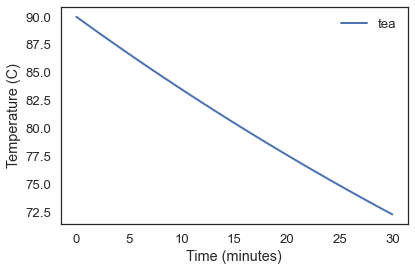

In [8]:
plot(results.T, label='tea')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

最终的温度结果：

In [9]:
tea.T_final = get_last_value(results.T)
T_final = get_last_value(results.T)

72.2996253904031

仿真运行的结果是一个TimeFrame对象，只有一列数据，对每个时间步有一个温度值。30分钟后茶的温度为72.3摄氏度。这比问题假设中的70度略微高了一点，我们可以通过试凑法对常数r进行调整，找到最合适的值，这会在后面进行介绍。

#### 程序封装 
让我们定义一个初始化函数：

In [10]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

然后整个程序可以整理为很简洁的形式仿真整个热茶冷却的过程：

In [11]:
tea = make_system(T_init=90, r=0.01, volume=300, t_end=30)
results = run_simulation(tea, update_func)
T_final = get_last_value(results.T)

72.2996253904031

### 练习
仿真50mL牛奶的温度变化，起始温度为5degC，在一个同样的保温杯里放15分钟，画出结果。
另外通过尝试，找出参数$r$的值，使得最终温度接近20degC。

In [12]:
# Solution goes here

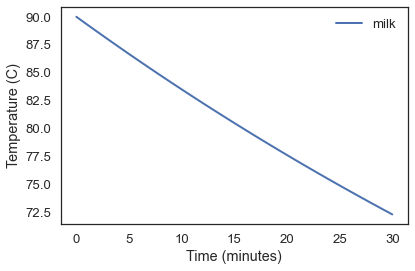

In [13]:
plot(results.T, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')